In [ ]:
import src
import keras.backend as K
import os
import numpy as np
import sys
import re
import math
from functools import partial
import io
from scipy import ndimage
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from  matplotlib.animation import FuncAnimation
from matplotlib import colors
from netCDF4 import Dataset
from IPython.display import clear_output
#data folder
sys.path.insert(0, 'C:/Users/pkicsiny/Desktop/TUM/3/ADL4CV/ADL4CV_project/trainings')

sys.path.insert(0, 'C:/Users/pkicsiny/Desktop/TUM/3/ADL4CV/data')
#forces CPU usage
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0" #"" or "-1" for CPU, "0" for GPU
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
def plot_advections(advected_aux_gen, advected_aux_truth, it):
    gen = advected_aux_gen[:5]
    truth =  advected_aux_truth[:5]
    fig, axs = plt.subplots(5, 2, figsize=(16, 16))
    for i in range(5):
        vmax = np.max([np.max(gen[i]), np.max(truth[i])])
        vmin = 0
        im = axs[i,0].imshow(gen[i, :,:,0], vmax=vmax,vmin=vmin)
        axs[i,0].axis('off')
        src.colorbar(im)
        axs[i,0].set_title("Advected generated frame")
        
        im = axs[i,1].imshow(truth[i, :,:,0], vmax=vmax,vmin=vmin)
        axs[i,1].axis('off')
        src.colorbar(im)
        axs[i,1].set_title("Advected reference frame")
        
    fig.savefig("Plots/advections_epoch %d.png" % it)
    plt.close()
    
class RandomWeightedAverage(keras.layers.Concatenate):
    """Takes a randomly-weighted average of two tensors. In geometric terms, this outputs a random point on the line
    between each pair of input points.
    Inheriting from _Merge is a little messy but it was the quickest solution I could think of.
    Improvements appreciated."""

    def _merge_function(self, inputs):
        weights = K.random_uniform((batch_size, 1, 1, 1))
        return (weights * inputs[0]) + ((1 - weights) * inputs[1]) if len(inputs) == 2 else \
               [(weights * inputs[0]) + ((1 - weights) * inputs[1]), (weights * inputs[2]) + ((1 - weights) * inputs[3])]

In [ ]:
past = 2
name = f"tgan_{past}-1"

Load dataset.

In [4]:
train, xval, test = src.load_datasets(past_frames=past+1)

Training data: (7500, 64, 64, 4)
Validation data: (1500, 64, 64, 4)
Test data: (1000, 64, 64, 4)


Split data to inputs and ground truth images.

In [5]:
gan_train, gan_truth, gan_val, gan_val_truth, gan_test, gan_test_truth = src.split_datasets(
            train[:2000], xval, test, past_frames=past+1, augment=True)

Data augmentation.
Shape of training data:  (8000, 64, 64, 3) 
Shape of training truth:  (8000, 64, 64, 1) 
Shape of validation data:  (1500, 64, 64, 3) 
Shape of validation truth:  (1500, 64, 64, 1) 
Shape of test data:  (1000, 64, 64, 3) 
Shape of test truth:  (1000, 64, 64, 1)


Calculate optical flows between frame t-1 and t.

In [ ]:
#optical flow of the augmented data of the first 2000 training images (8000 images)
#vx, vy = src.optical_flow(gan_train[:,:,:,-2:-1], gan_train[:,:,:,-1:], window_size=4, tau=1e-2, init=1) # (n,:,:,1)

Save optical flows

In [ ]:
#np.savez_compressed(f"{name}_vx_2000",vx) #2000 denotes that they re the flo2 of the first 2000 samples from the training dataset
#np.savez_compressed(f"{name}_vy_2000",vy)

If optical flows are saved, load them

In [6]:
vx = np.load(sys.path[0]+f"/{name}_vx_2000.npz")["arr_0"]
vy = np.load(sys.path[0]+f"/{name}_vy_2000.npz")["arr_0"]

Preprocess optical flows

In [7]:
normalized_optical_flow = src.normalize_flows(vx, vy)
flows = np.transpose([[ndimage.median_filter(image[..., ch], 4) for ch in range(2)] for image in normalized_optical_flow], (0, 2, 3, 1))

Make discriminator labels.

In [9]:
batch_size=16
GRADIENT_PENALTY_WEIGHT = 10

Make generator but don't compile.

In [ ]:
generator = src.unet((64, 64, past), dropout=0, batchnorm=True, kernel_size=4, feature_mult=1)

Make discriminators and compile.

In [11]:
s_discriminator = src.spatial_discriminator(condition_shape=(64, 64, past), dropout = 0.25, batchnorm=False, wgan=True)
s_discriminator.compile(loss=src.wasserstein_loss,
#                        optimizer=keras.optimizers.RMSprop(lr=0.00005))

In [12]:
t_discriminator = src.temporal_discriminator(dropout = 0.25, batchnorm=False, wgan=True)
#t_discriminator.compile(loss=src.wasserstein_loss,
#                        optimizer=keras.optimizers.RMSprop(lr=0.00005))

Inputs and outputs of the GAN.

In [13]:
frame_t = keras.layers.Input(shape=(64, 64, past), name='input_condition_')
adv = keras.layers.Input(shape=(64, 64, 1), name="advected_frame")

In [14]:
generated = generator(frame_t)
s_score_fake = s_discriminator([frame_t, generated])
t_score_fake = t_discriminator([adv, generated])

Freeze discriminator weights.

In [15]:
s_discriminator.trainable = False
t_discriminator.trainable = False

Compile combined model.

In [16]:
loss_weights=[0, 1, 1]

In [17]:
combined = keras.models.Model(inputs=[frame_t, adv], outputs=[generated, s_score_fake, t_score_fake], name="combined_model")

In [18]:
combined.compile(loss=[src.custom_loss(loss="l1"),
                       src.wasserstein_loss,
                       src.wasserstein_loss],
                 optimizer=keras.optimizers.RMSprop(lr=0.00005),
                 loss_weights=loss_weights)

***Using L1 loss.***


Make gradient penalty

In [19]:
for l in s_discriminator.layers:
    l.trainable = True
for l in t_discriminator.layers:
    l.trainable = True
for l in generator.layers:
    l.trainable = False

s_discriminator.trainable = True
t_discriminator.trainable = True
generator.trainable = False

Inputs and outputs

In [20]:
real_samples = keras.layers.Input(shape=(64, 64, 1), name="ground_truth")
adv_real = keras.layers.Input(shape=(64, 64, 1), name="real_advected")

frame_t = keras.layers.Input(shape=(64, 64, past), name="input_sequence")
adv = keras.layers.Input(shape=(64, 64, 1), name="fake_advected")

generated = generator(frame_t)

In [21]:
ds_output_generated = s_discriminator([frame_t, generated])
ds_output_real = s_discriminator([frame_t, real_samples])
s_averaged_samples = RandomWeightedAverage()([real_samples, generated])
ds_output_avg = s_discriminator([frame_t, s_averaged_samples])

dt_output_generated = t_discriminator([adv, generated])
dt_output_real = t_discriminator([adv_real, real_samples])
t_averaged_samples, t_averaged_advections = RandomWeightedAverage()([real_samples, generated, adv_real, adv])
dt_output_avg = t_discriminator([t_averaged_advections, t_averaged_samples])

Partial losses

In [22]:
s_partial_gp_loss = partial(src.gradient_penalty_loss,
                          averaged_samples=s_averaged_samples,
                          gradient_penalty_weight=GRADIENT_PENALTY_WEIGHT)
s_partial_gp_loss.__name__ = 's_gradient_penalty' 

t_partial_gp_loss = partial(src.gradient_penalty_loss,
                          averaged_samples=t_averaged_samples,
                          gradient_penalty_weight=GRADIENT_PENALTY_WEIGHT)
t_partial_gp_loss.__name__ = 't_gradient_penalty' 

Compile

In [23]:
Ds = keras.models.Model(inputs=[frame_t, real_samples],
                                   outputs=[ds_output_real,
                                            ds_output_generated,
                                            ds_output_avg])

Dt = keras.models.Model(inputs=[frame_t, real_samples, adv, adv_real],
                                   outputs=[dt_output_real,
                                            dt_output_generated,
                                            dt_output_avg])

In [24]:
Ds.compile(optimizer=keras.optimizers.RMSprop(lr=0.00005),
          loss=[src.wasserstein_loss, src.wasserstein_loss, s_partial_gp_loss])

Dt.compile(optimizer=keras.optimizers.RMSprop(lr=0.00005),
          loss=[src.wasserstein_loss, src.wasserstein_loss, t_partial_gp_loss])

Train x epochs.

In [30]:
RND = 777
np.random.seed(RND)
iterations = 4908
g = 1
nb_batches = int(gan_train.shape[0] / batch_size)
positive_y = np.ones((batch_size, 1), dtype=np.float32)
negative_y = -positive_y
dummy_y = np.zeros((batch_size, 1), dtype=np.float32)

In [26]:
log = {"g_loss":[],
       "ds_loss":[],
       "dt_loss":[],
       "ds_loss_real":[],
       "ds_loss_fake":[],
       "ds_loss_avg":[],
       'ds_loss_wgan':[],
       "dt_loss_real":[],
       "dt_loss_fake":[],
       "dt_loss_avg":[],
       'dt_loss_wgan':[]}


201/0 [Ds loss real: 43.699466705322266 Ds loss fake: -71.98973083496094 Ds loss avg: 6.0840744972229] 
201/0 [Dt loss real: -145243.5625 Dt loss fake: 108317.71875 Dt loss avg: 8063.4501953125]
201/1 [Ds loss real: 43.314720153808594 Ds loss fake: -65.57830047607422 Ds loss avg: 5.565237045288086] 
201/1 [Dt loss real: -197530.921875 Dt loss fake: 129655.8125 Dt loss avg: 8322.69921875]
201/2 [Ds loss real: 31.844066619873047 Ds loss fake: -55.114742279052734 Ds loss avg: 4.992550373077393] 
201/2 [Dt loss real: -174895.5625 Dt loss fake: 118254.1875 Dt loss avg: 8347.28515625]
201/3 [Ds loss real: 32.610511779785156 Ds loss fake: -54.18421936035156 Ds loss avg: 5.353785514831543] 
201/3 [Dt loss real: -180305.8125 Dt loss fake: 120876.28125 Dt loss avg: 8116.05224609375]
201/4 [Ds loss real: 33.3875617980957 Ds loss fake: -60.77596664428711 Ds loss avg: 4.631434917449951] 
201/4 [Dt loss real: -177722.234375 Dt loss fake: 121932.8046875 Dt loss avg: 8115.375]
201/5 [Ds loss real: 35

204/9 [Ds loss real: 39.65471649169922 Ds loss fake: -64.34651947021484 Ds loss avg: 5.698215484619141] 
204/9 [Dt loss real: -166807.4375 Dt loss fake: 118088.6796875 Dt loss avg: 8019.263671875]
 204 [G loss: [-148871.39, 0.28888083, 67.604774, -148939.0]] 
 Ds: real loss: 39.65471649169922, fake loss: -64.34651947021484, avg loss: 5.698215484619141 
 Dt: real loss: -166807.4375, fake loss: 118088.6796875, avg loss: 8019.263671875
205/0 [Ds loss real: 34.833038330078125 Ds loss fake: -56.79246520996094 Ds loss avg: 5.385209083557129] 
205/0 [Dt loss real: -194472.34375 Dt loss fake: 138081.25 Dt loss avg: 8348.7177734375]
205/1 [Ds loss real: 39.7033805847168 Ds loss fake: -63.96271896362305 Ds loss avg: 4.936077117919922] 
205/1 [Dt loss real: -185131.359375 Dt loss fake: 136299.40625 Dt loss avg: 8307.708984375]
205/2 [Ds loss real: 37.06315612792969 Ds loss fake: -64.10629272460938 Ds loss avg: 5.837164878845215] 
205/2 [Dt loss real: -213098.0625 Dt loss fake: 149047.75 Dt loss a

208/6 [Ds loss real: 34.305397033691406 Ds loss fake: -55.94599914550781 Ds loss avg: 5.942652702331543] 
208/6 [Dt loss real: -231824.546875 Dt loss fake: 157640.15625 Dt loss avg: 7620.927734375]
208/7 [Ds loss real: 27.90033721923828 Ds loss fake: -49.796958923339844 Ds loss avg: 4.945515155792236] 
208/7 [Dt loss real: -201432.484375 Dt loss fake: 147960.0625 Dt loss avg: 7554.0673828125]
208/8 [Ds loss real: 33.921730041503906 Ds loss fake: -58.90143966674805 Ds loss avg: 4.791752815246582] 
208/8 [Dt loss real: -227663.765625 Dt loss fake: 162429.6875 Dt loss avg: 7555.11767578125]
208/9 [Ds loss real: 37.373897552490234 Ds loss fake: -63.20702362060547 Ds loss avg: 5.751140594482422] 
208/9 [Dt loss real: -246410.9375 Dt loss fake: 171965.28125 Dt loss avg: 7633.2060546875]
 208 [G loss: [-173604.77, 0.28787094, 67.257904, -173672.03]] 
 Ds: real loss: 37.373897552490234, fake loss: -63.20702362060547, avg loss: 5.751140594482422 
 Dt: real loss: -246410.9375, fake loss: 171965.

212/3 [Ds loss real: 29.815637588500977 Ds loss fake: -54.324623107910156 Ds loss avg: 5.357784748077393] 
212/3 [Dt loss real: -227681.046875 Dt loss fake: 169929.203125 Dt loss avg: 7081.54736328125]
212/4 [Ds loss real: 28.278079986572266 Ds loss fake: -48.55509948730469 Ds loss avg: 4.685602188110352] 
212/4 [Dt loss real: -236244.53125 Dt loss fake: 174133.15625 Dt loss avg: 7123.47509765625]
212/5 [Ds loss real: 37.121498107910156 Ds loss fake: -63.510887145996094 Ds loss avg: 5.2066144943237305] 
212/5 [Dt loss real: -266026.34375 Dt loss fake: 192540.203125 Dt loss avg: 7366.44921875]
212/6 [Ds loss real: 33.76982498168945 Ds loss fake: -59.29231262207031 Ds loss avg: 5.155113220214844] 
212/6 [Dt loss real: -247558.5 Dt loss fake: 194805.15625 Dt loss avg: 7142.67236328125]
212/7 [Ds loss real: 32.413780212402344 Ds loss fake: -57.360626220703125 Ds loss avg: 5.247165679931641] 
212/7 [Dt loss real: -248889.734375 Dt loss fake: 180955.828125 Dt loss avg: 7009.154296875]
212/8 

216/0 [Ds loss real: 37.473445892333984 Ds loss fake: -65.11210632324219 Ds loss avg: 5.985577583312988] 
216/0 [Dt loss real: -290398.875 Dt loss fake: 213300.59375 Dt loss avg: 6534.00439453125]
216/1 [Ds loss real: 33.563995361328125 Ds loss fake: -56.835060119628906 Ds loss avg: 6.111330509185791] 
216/1 [Dt loss real: -285312.875 Dt loss fake: 213350.96875 Dt loss avg: 6631.60009765625]
216/2 [Ds loss real: 33.877471923828125 Ds loss fake: -55.89720153808594 Ds loss avg: 5.153824329376221] 
216/2 [Dt loss real: -265957.5 Dt loss fake: 202977.421875 Dt loss avg: 6533.85986328125]
216/3 [Ds loss real: 31.084510803222656 Ds loss fake: -52.54673385620117 Ds loss avg: 4.913181304931641] 
216/3 [Dt loss real: -275379.1875 Dt loss fake: 202430.671875 Dt loss avg: 6535.9853515625]
216/4 [Ds loss real: 33.124839782714844 Ds loss fake: -55.836463928222656 Ds loss avg: 4.718650817871094] 
216/4 [Dt loss real: -241322.25 Dt loss fake: 190528.4375 Dt loss avg: 6475.2197265625]
216/5 [Ds loss r

219/9 [Ds loss real: 30.38103485107422 Ds loss fake: -54.54872131347656 Ds loss avg: 5.371377944946289] 
219/9 [Dt loss real: -348005.46875 Dt loss fake: 256514.671875 Dt loss avg: 6178.53564453125]
 219 [G loss: [-234056.66, 0.296691, 55.77514, -234112.44]] 
 Ds: real loss: 30.38103485107422, fake loss: -54.54872131347656, avg loss: 5.371377944946289 
 Dt: real loss: -348005.46875, fake loss: 256514.671875, avg loss: 6178.53564453125
220/0 [Ds loss real: 31.065773010253906 Ds loss fake: -54.74925994873047 Ds loss avg: 4.654758930206299] 
220/0 [Dt loss real: -303160.9375 Dt loss fake: 231643.171875 Dt loss avg: 6139.595703125]
220/1 [Ds loss real: 31.7474422454834 Ds loss fake: -56.65235900878906 Ds loss avg: 4.2978973388671875] 
220/1 [Dt loss real: -275363.21875 Dt loss fake: 204065.46875 Dt loss avg: 5931.6767578125]
220/2 [Ds loss real: 31.3183650970459 Ds loss fake: -55.20738220214844 Ds loss avg: 4.677813529968262] 
220/2 [Dt loss real: -323471.5 Dt loss fake: 234992.90625 Dt lo

223/6 [Ds loss real: 32.82506561279297 Ds loss fake: -56.19044494628906 Ds loss avg: 4.794870853424072] 
223/6 [Dt loss real: -399087.0 Dt loss fake: 298178.5625 Dt loss avg: 5742.947265625]
223/7 [Ds loss real: 29.991565704345703 Ds loss fake: -50.479896545410156 Ds loss avg: 4.809972763061523] 
223/7 [Dt loss real: -346668.3125 Dt loss fake: 256884.21875 Dt loss avg: 5675.79296875]
223/8 [Ds loss real: 27.15114402770996 Ds loss fake: -47.809120178222656 Ds loss avg: 4.657695293426514] 
223/8 [Dt loss real: -335258.25 Dt loss fake: 247436.625 Dt loss avg: 5564.9404296875]
223/9 [Ds loss real: 34.46233367919922 Ds loss fake: -55.09515380859375 Ds loss avg: 4.721796035766602] 
223/9 [Dt loss real: -369666.6875 Dt loss fake: 277330.90625 Dt loss avg: 5736.67578125]
 223 [G loss: [-224478.02, 0.2604934, 46.182556, -224524.2]] 
 Ds: real loss: 34.46233367919922, fake loss: -55.09515380859375, avg loss: 4.721796035766602 
 Dt: real loss: -369666.6875, fake loss: 277330.90625, avg loss: 5736

227/4 [Ds loss real: 27.158737182617188 Ds loss fake: -48.595184326171875 Ds loss avg: 4.248504161834717] 
227/4 [Dt loss real: -362466.875 Dt loss fake: 277058.1875 Dt loss avg: 5003.404296875]
227/5 [Ds loss real: 26.496437072753906 Ds loss fake: -51.45867156982422 Ds loss avg: 4.804060459136963] 
227/5 [Dt loss real: -396181.53125 Dt loss fake: 311628.375 Dt loss avg: 5321.3876953125]
227/6 [Ds loss real: 24.460956573486328 Ds loss fake: -45.592323303222656 Ds loss avg: 4.756839752197266] 
227/6 [Dt loss real: -357398.125 Dt loss fake: 281683.5 Dt loss avg: 5256.7470703125]
227/7 [Ds loss real: 26.974763870239258 Ds loss fake: -46.298683166503906 Ds loss avg: 4.511345863342285] 
227/7 [Dt loss real: -389532.0625 Dt loss fake: 291037.5 Dt loss avg: 5352.5908203125]
227/8 [Ds loss real: 29.60645866394043 Ds loss fake: -51.59197998046875 Ds loss avg: 4.817351341247559] 
227/8 [Dt loss real: -384258.875 Dt loss fake: 289064.0625 Dt loss avg: 5366.609375]
227/9 [Ds loss real: 29.21836090

231/2 [Ds loss real: 29.971355438232422 Ds loss fake: -54.14540481567383 Ds loss avg: 4.5470733642578125] 
231/2 [Dt loss real: -417106.5 Dt loss fake: 344734.84375 Dt loss avg: 4776.34130859375]
231/3 [Ds loss real: 27.155975341796875 Ds loss fake: -50.09089660644531 Ds loss avg: 4.818380355834961] 
231/3 [Dt loss real: -421611.9375 Dt loss fake: 342109.625 Dt loss avg: 4840.24072265625]
231/4 [Ds loss real: 29.23790168762207 Ds loss fake: -51.02692413330078 Ds loss avg: 4.319567680358887] 
231/4 [Dt loss real: -421677.0 Dt loss fake: 329921.78125 Dt loss avg: 4614.97412109375]
231/5 [Ds loss real: 28.283245086669922 Ds loss fake: -50.98674011230469 Ds loss avg: 4.937020778656006] 
231/5 [Dt loss real: -442148.4375 Dt loss fake: 340153.6875 Dt loss avg: 4741.953125]
231/6 [Ds loss real: 26.615922927856445 Ds loss fake: -50.0487174987793 Ds loss avg: 4.849325180053711] 
231/6 [Dt loss real: -439956.6875 Dt loss fake: 345090.875 Dt loss avg: 4840.912109375]
231/7 [Ds loss real: 26.27328

235/0 [Ds loss real: 25.665729522705078 Ds loss fake: -48.21571350097656 Ds loss avg: 4.180870532989502] 
235/0 [Dt loss real: -468668.6875 Dt loss fake: 387499.5625 Dt loss avg: 4407.7431640625]
235/1 [Ds loss real: 23.816429138183594 Ds loss fake: -40.89643859863281 Ds loss avg: 3.8497185707092285] 
235/1 [Dt loss real: -473377.9375 Dt loss fake: 370038.25 Dt loss avg: 4603.51171875]
235/2 [Ds loss real: 26.39395523071289 Ds loss fake: -46.82907485961914 Ds loss avg: 3.9006659984588623] 
235/2 [Dt loss real: -400464.21875 Dt loss fake: 333929.1875 Dt loss avg: 4588.03759765625]
235/3 [Ds loss real: 26.558929443359375 Ds loss fake: -48.357643127441406 Ds loss avg: 4.536634922027588] 
235/3 [Dt loss real: -474768.3125 Dt loss fake: 365079.1875 Dt loss avg: 4427.634765625]
235/4 [Ds loss real: 29.848569869995117 Ds loss fake: -52.17097473144531 Ds loss avg: 4.6226301193237305] 
235/4 [Dt loss real: -466917.375 Dt loss fake: 378977.75 Dt loss avg: 4393.6787109375]
235/5 [Ds loss real: 31

238/9 [Ds loss real: 25.559587478637695 Ds loss fake: -45.98329162597656 Ds loss avg: 4.419189929962158] 
238/9 [Dt loss real: -543699.25 Dt loss fake: 402423.8125 Dt loss avg: 4160.869140625]
 238 [G loss: [-341576.12, 0.26626638, 46.134865, -341622.25]] 
 Ds: real loss: 25.559587478637695, fake loss: -45.98329162597656, avg loss: 4.419189929962158 
 Dt: real loss: -543699.25, fake loss: 402423.8125, avg loss: 4160.869140625
239/0 [Ds loss real: 29.086566925048828 Ds loss fake: -47.16338348388672 Ds loss avg: 3.9927845001220703] 
239/0 [Dt loss real: -440944.625 Dt loss fake: 346345.78125 Dt loss avg: 4017.96142578125]
239/1 [Ds loss real: 27.138614654541016 Ds loss fake: -47.57172775268555 Ds loss avg: 4.527379035949707] 
239/1 [Dt loss real: -515761.40625 Dt loss fake: 415202.75 Dt loss avg: 4142.0576171875]
239/2 [Ds loss real: 24.663841247558594 Ds loss fake: -46.425682067871094 Ds loss avg: 4.175220489501953] 
239/2 [Dt loss real: -507317.1875 Dt loss fake: 397192.15625 Dt loss a

242/7 [Ds loss real: 31.059619903564453 Ds loss fake: -50.74986267089844 Ds loss avg: 4.712465286254883] 
242/7 [Dt loss real: -467815.34375 Dt loss fake: 399018.78125 Dt loss avg: 3532.587890625]
242/8 [Ds loss real: 29.344892501831055 Ds loss fake: -52.934776306152344 Ds loss avg: 4.014401912689209] 
242/8 [Dt loss real: -631893.375 Dt loss fake: 508829.90625 Dt loss avg: 3670.439697265625]
242/9 [Ds loss real: 28.63717269897461 Ds loss fake: -48.1571044921875 Ds loss avg: 3.972548246383667] 
242/9 [Dt loss real: -506541.625 Dt loss fake: 424636.0625 Dt loss avg: 3761.24267578125]
 242 [G loss: [-467379.9, 0.27560803, 48.744286, -467428.66]] 
 Ds: real loss: 28.63717269897461, fake loss: -48.1571044921875, avg loss: 3.972548246383667 
 Dt: real loss: -506541.625, fake loss: 424636.0625, avg loss: 3761.24267578125
243/0 [Ds loss real: 29.40161895751953 Ds loss fake: -50.738189697265625 Ds loss avg: 4.2624616622924805] 
243/0 [Dt loss real: -525158.375 Dt loss fake: 397036.0 Dt loss av

246/4 [Ds loss real: 30.555255889892578 Ds loss fake: -53.79629898071289 Ds loss avg: 4.445363998413086] 
246/4 [Dt loss real: -645684.8125 Dt loss fake: 526948.25 Dt loss avg: 3198.5458984375]
246/5 [Ds loss real: 25.69919204711914 Ds loss fake: -45.28971862792969 Ds loss avg: 4.644509315490723] 
246/5 [Dt loss real: -628112.0 Dt loss fake: 515595.4375 Dt loss avg: 3154.32421875]
246/6 [Ds loss real: 25.582054138183594 Ds loss fake: -45.669090270996094 Ds loss avg: 4.185128211975098] 
246/6 [Dt loss real: -588808.75 Dt loss fake: 483729.71875 Dt loss avg: 3103.14599609375]
246/7 [Ds loss real: 29.991321563720703 Ds loss fake: -51.026123046875 Ds loss avg: 4.252089023590088] 
246/7 [Dt loss real: -646125.375 Dt loss fake: 522955.375 Dt loss avg: 3129.181396484375]
246/8 [Ds loss real: 24.857505798339844 Ds loss fake: -45.982357025146484 Ds loss avg: 4.028860092163086] 
246/8 [Dt loss real: -631133.0 Dt loss fake: 523373.4375 Dt loss avg: 3216.74072265625]
246/9 [Ds loss real: 22.651601

250/1 [Ds loss real: 28.62938690185547 Ds loss fake: -48.810791015625 Ds loss avg: 3.7571122646331787] 
250/1 [Dt loss real: -670252.3125 Dt loss fake: 557473.875 Dt loss avg: 3109.7001953125]
250/2 [Ds loss real: 26.586843490600586 Ds loss fake: -45.998626708984375 Ds loss avg: 4.301660537719727] 
250/2 [Dt loss real: -601649.0 Dt loss fake: 504662.53125 Dt loss avg: 3064.449462890625]
250/3 [Ds loss real: 21.793142318725586 Ds loss fake: -40.37066650390625 Ds loss avg: 3.853578567504883] 
250/3 [Dt loss real: -601998.0625 Dt loss fake: 485127.71875 Dt loss avg: 3236.19384765625]
250/4 [Ds loss real: 25.43967056274414 Ds loss fake: -52.001827239990234 Ds loss avg: 4.567326068878174] 
250/4 [Dt loss real: -564626.0 Dt loss fake: 469732.46875 Dt loss avg: 3061.4677734375]
250/5 [Ds loss real: 23.901294708251953 Ds loss fake: -46.413963317871094 Ds loss avg: 4.178980350494385] 
250/5 [Dt loss real: -668593.9375 Dt loss fake: 540277.0 Dt loss avg: 3177.7158203125]
250/6 [Ds loss real: 23.

 253 [G loss: [-555530.5, 0.26473224, 43.143238, -555573.6]] 
 Ds: real loss: 25.502017974853516, fake loss: -45.553993225097656, avg loss: 4.507472038269043 
 Dt: real loss: -735863.0, fake loss: 618396.0, avg loss: 2932.724853515625
254/0 [Ds loss real: 24.841018676757812 Ds loss fake: -43.29045867919922 Ds loss avg: 4.145240783691406] 
254/0 [Dt loss real: -670464.875 Dt loss fake: 553997.875 Dt loss avg: 2655.87451171875]
254/1 [Ds loss real: 25.20548439025879 Ds loss fake: -45.70622634887695 Ds loss avg: 4.094287395477295] 
254/1 [Dt loss real: -730053.3125 Dt loss fake: 589254.625 Dt loss avg: 2714.96142578125]
254/2 [Ds loss real: 25.476497650146484 Ds loss fake: -47.26726531982422 Ds loss avg: 4.488343715667725] 
254/2 [Dt loss real: -719486.625 Dt loss fake: 566518.5 Dt loss avg: 2490.75927734375]
254/3 [Ds loss real: 23.442176818847656 Ds loss fake: -46.167076110839844 Ds loss avg: 4.445219039916992] 
254/3 [Dt loss real: -748479.375 Dt loss fake: 640063.875 Dt loss avg: 2559

257/7 [Ds loss real: 25.030616760253906 Ds loss fake: -44.35212326049805 Ds loss avg: 4.1071977615356445] 
257/7 [Dt loss real: -753670.875 Dt loss fake: 619118.25 Dt loss avg: 2287.017822265625]
257/8 [Ds loss real: 24.11699676513672 Ds loss fake: -46.32105255126953 Ds loss avg: 4.225702285766602] 
257/8 [Dt loss real: -805588.25 Dt loss fake: 656553.6875 Dt loss avg: 2173.16845703125]
257/9 [Ds loss real: 24.993850708007812 Ds loss fake: -49.41651916503906 Ds loss avg: 4.43220329284668] 
257/9 [Dt loss real: -702582.25 Dt loss fake: 604690.75 Dt loss avg: 2265.052734375]
 257 [G loss: [-554219.1, 0.27855697, 40.874977, -554260.0]] 
 Ds: real loss: 24.993850708007812, fake loss: -49.41651916503906, avg loss: 4.43220329284668 
 Dt: real loss: -702582.25, fake loss: 604690.75, avg loss: 2265.052734375
258/0 [Ds loss real: 23.624549865722656 Ds loss fake: -46.236717224121094 Ds loss avg: 4.650458812713623] 
258/0 [Dt loss real: -699777.3125 Dt loss fake: 578317.375 Dt loss avg: 2116.1455

261/5 [Ds loss real: 22.056072235107422 Ds loss fake: -43.62253952026367 Ds loss avg: 4.233441352844238] 
261/5 [Dt loss real: -839624.3125 Dt loss fake: 683261.1875 Dt loss avg: 2849.548828125]
261/6 [Ds loss real: 22.35305404663086 Ds loss fake: -45.59016418457031 Ds loss avg: 4.091142654418945] 
261/6 [Dt loss real: -812765.375 Dt loss fake: 674290.0 Dt loss avg: 2486.909423828125]
261/7 [Ds loss real: 23.5191650390625 Ds loss fake: -44.435176849365234 Ds loss avg: 4.712944507598877] 
261/7 [Dt loss real: -835561.875 Dt loss fake: 715955.875 Dt loss avg: 2445.39990234375]
261/8 [Ds loss real: 24.427852630615234 Ds loss fake: -47.976409912109375 Ds loss avg: 4.581886291503906] 
261/8 [Dt loss real: -840585.375 Dt loss fake: 685744.625 Dt loss avg: 2125.0615234375]
261/9 [Ds loss real: 22.22608184814453 Ds loss fake: -47.19350814819336 Ds loss avg: 4.904313087463379] 
261/9 [Dt loss real: -779426.875 Dt loss fake: 703651.375 Dt loss avg: 2052.75634765625]
 261 [G loss: [-732001.8, 0.2

265/3 [Ds loss real: 26.36450958251953 Ds loss fake: -49.42882537841797 Ds loss avg: 4.709589958190918] 
265/3 [Dt loss real: -833283.0 Dt loss fake: 694617.25 Dt loss avg: 2283.3310546875]
265/4 [Ds loss real: 20.00107192993164 Ds loss fake: -42.44319152832031 Ds loss avg: 4.159515380859375] 
265/4 [Dt loss real: -889313.0 Dt loss fake: 754526.0 Dt loss avg: 2158.6708984375]
265/5 [Ds loss real: 22.53575897216797 Ds loss fake: -46.465850830078125 Ds loss avg: 4.51332950592041] 
265/5 [Dt loss real: -850926.0 Dt loss fake: 727043.75 Dt loss avg: 2404.64892578125]
265/6 [Ds loss real: 24.718170166015625 Ds loss fake: -45.82731628417969 Ds loss avg: 4.300372123718262] 
265/6 [Dt loss real: -828589.0 Dt loss fake: 685369.25 Dt loss avg: 2377.285888671875]
265/7 [Ds loss real: 21.802051544189453 Ds loss fake: -46.19163513183594 Ds loss avg: 4.790604591369629] 
265/7 [Dt loss real: -1048300.875 Dt loss fake: 794950.0 Dt loss avg: 2655.01123046875]
265/8 [Ds loss real: 21.21985626220703 Ds l

KeyboardInterrupt: 

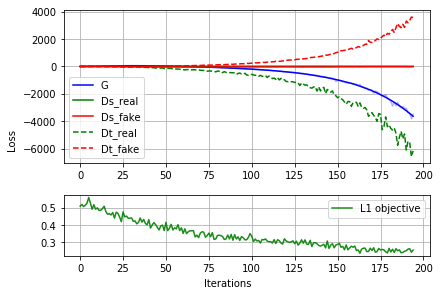

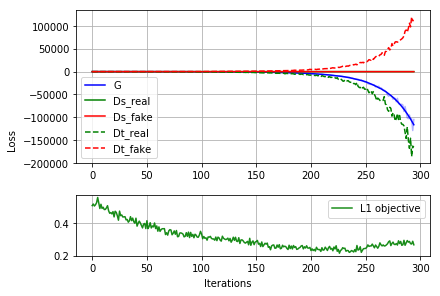

In [31]:
for it in range(iterations):
#batch
#idx = range(it%nb_batches * batch_size,(it%nb_batches + 1) * batch_size)
    if (it % 1000) < 25 or it % 500 == 0: # 25 times in 1000, every 500th
        d_iters = 10
    else:
        d_iters = 10
        
    s_discriminator.trainable = True
    for l in s_discriminator.layers: l.trainable = True
    t_discriminator.trainable = True
    for l in t_discriminator.layers: l.trainable = True
    generator.trainable = False
    for l in generator.layers: l.trainable = False
            
    for d_it in range(d_iters):
        idx = np.random.choice(gan_train.shape[0], batch_size, replace=False)
        real_imgs = gan_truth[idx]
        training_batch = gan_train[idx,:,:,1:]
        
        ds_loss = Ds.train_on_batch([training_batch, real_imgs], [negative_y, positive_y, dummy_y])
    
        idx = np.random.choice(gan_train.shape[0], batch_size, replace=False)
        real_imgs = gan_truth[idx]
        training_batch = gan_train[idx,:,:,1:]
        aux_batch = gan_train[idx,:,:,:-1]
            
        advected_aux_gen = generator.predict(aux_batch)
        advected_aux_truth = training_batch[:,:,:,-1:]
        for i in range(10):
            advected_aux_gen = np.array([src.advect(sample, order=2) for sample in np.concatenate((advected_aux_gen, -flows[idx]), axis=-1)])
            advected_aux_truth = np.array([src.advect(sample, order=2) for sample in np.concatenate((advected_aux_truth, -flows[idx]), axis=-1)])
        
        dt_loss = Dt.train_on_batch([training_batch,
                                     real_imgs,
                                     advected_aux_gen,
                                     advected_aux_truth], [negative_y, positive_y, dummy_y])
        
        print(f"{it}/{d_it} [Ds loss real: {ds_loss[1]} Ds loss fake: {ds_loss[2]} Ds loss avg: {ds_loss[3]}] \n"+
              f"{it}/{d_it} [Dt loss real: {dt_loss[1]} Dt loss fake: {dt_loss[2]} Dt loss avg: {dt_loss[3]}]")

#Generator
    s_discriminator.trainable = False
    for l in s_discriminator.layers: l.trainable = False
    t_discriminator.trainable = False
    for l in t_discriminator.layers: l.trainable = False
    generator.trainable = True
    for l in generator.layers: l.trainable = True
        
    for tg in range(g):
        idx = np.random.choice(gan_train.shape[0], batch_size, replace=False)
        real_imgs = gan_truth[idx]
        training_batch = gan_train[idx,:,:,1:]
        aux_batch = gan_train[idx,:,:,:-1]

        advected = generator.predict(aux_batch)
        for i in range(10):
            advected = np.array([src.advect(sample, order=2) for sample in np.concatenate((advected, -flows[idx]), axis=-1)])  
    
        g_loss = combined.train_on_batch([training_batch, advected], [real_imgs, negative_y, negative_y])
    
    log["g_loss"].append(g_loss)
    log["ds_loss"].append(ds_loss) 
    log["dt_loss"].append(dt_loss)
    log["ds_loss_real"].append(ds_loss[1])
    log["ds_loss_fake"].append(ds_loss[2])
    log["ds_loss_avg"].append(ds_loss[3])
    log['ds_loss_wgan'].append(-1 * ds_loss[1] + ds_loss[2])
    log["dt_loss_real"].append(dt_loss[1])
    log["dt_loss_fake"].append(dt_loss[2])
    log["dt_loss_avg"].append(dt_loss[3])
    log['dt_loss_wgan'].append(-1 * dt_loss[1] + dt_loss[2])
    
    
    print(f"\033[1m {it} [G loss: {g_loss}]\033[0m \n"+
          f" Ds: real loss: {ds_loss[1]}, fake loss: {ds_loss[2]}, avg loss: {ds_loss[3]} \n"+
          f" Dt: real loss: {dt_loss[1]}, fake loss: {dt_loss[2]}, avg loss: {dt_loss[3]}")
    if it%100 == 0 and it>0:
        src.sample_images(it, gan_test[...,1:], gan_test_truth, past, generator)
        plot_advections(advected_aux_gen, advected_aux_truth, it)
        src.plot_temporal_training_curves(log, it, name, wgan=True)
        src.update_output("")

src.sample_images(iterations, gan_test[...,1:], gan_test_truth, past, generator)
src.plot_temporal_training_curves(log, iterations, name, wgan=True)

In [1]:
plt.plot(log["dt_loss_real"],label="real")
plt.plot(log["dt_loss_fake"],label="fake")
plt.grid()
plt.legend()

NameError: name 'plt' is not defined

In [ ]:
src.plot_temporal_training_curves(log, iterations, name, wgan=True)

In [ ]:
total_g_loss = np.array(log["g_loss"])[:,0]
total_d_loss = np.array(log["d_loss"])[:,0]
smoothed_tgl = src.smooth(np.array(log["g_loss"])[:,0])
smoothed_tdl = src.smooth(np.array(log["d_loss"])[:,0])
objective_loss = np.array(log["g_loss"])[:,1]

# plot 'em
f, (a0, a1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[5, 2]})
a0.plot(total_g_loss, alpha=0.3, c="b")
a0.plot(total_d_loss, alpha=0.3, c="orange")
a0.plot(smoothed_tgl, c="b", label="generator")
a0.grid()
a0.plot(smoothed_tdl, c="orange", label="discriminator")
a0.legend()
a1.plot(objective_loss, alpha=0.9, c="green", label="L1 objective")
a1.grid()
a1.legend()
f.text(0.5, 0, 'Iterations', ha='center', va='center')
f.text(0, 0.5, 'Loss', ha='center', va='center', rotation='vertical')

f.tight_layout()
f.savefig(name+'_curves.png')

## Save features

Save model history

In [ ]:
np.save(name+"_log",log)

Save model weights

In [ ]:
combined.save_weights(name+"_model.h5")

Load model and predict

In [ ]:
combined.load_weights(sys.path[1]+"/"+name+"/"+name+"_model.h5")

Predict future frames. Loads a 20 long sequence with 1000 sequence samples.

In [ ]:
sequence_test = src.load_datasets(prediction=True)

In [ ]:
sequence_test = src.augment_data(sequence_test[:100])

In [ ]:
sequence_test.shape

In [ ]:
generator = combined.layers[1]

In [ ]:
#test
predictions = {}
past_frames = sequence_test[...,0:past]
test_truth = sequence_test[...,past:past+1]
for t in range(5):
    future = generator.predict(past_frames, batch_size=64)
    predictions[f"{t}"] = future
    past_frames = np.concatenate((past_frames[:,:,:,1:], predictions[f"{t}"]), axis=-1)
    test_truth = sequence_test[...,past+1+t:past+2+t]

Save example predictions

In [ ]:
def save_examples(name, test, predictions_dict, past, samples=0):
    fig, axs = plt.subplots(len(samples)*2,past+len(predictions_dict.keys()), figsize=(32, 32))
    fig.subplots_adjust(wspace=0.3, hspace=0.0)
    for n in range(len(samples)):
        vmax = np.max(test[n,:,:,:past])
        vmin = 0
        print(test.shape)
        for i in range(past):
            im = axs[2*n,i].imshow(test[samples[n], :,:,i], vmax=vmax,vmin=vmin)
            axs[2*n,i].axis('off')
            axs[2*n,i].set_title(f"Past frame {i+1}")
            src.colorbar(im)
            im = axs[2*n+1,i].imshow(test[samples[n], :,:,i], vmax=vmax,vmin=vmin)
            axs[2*n+1,i].axis('off')
            axs[2*n+1,i].set_title(f"Past frame {i+1}")
            src.colorbar(im)
        for i in range(past,past+len(predictions_dict.keys())):
            im = axs[2*n,i].imshow(predictions_dict[f"{i-past}"][samples[n], :,:,0], vmax=vmax, vmin=vmin)
            axs[2*n,i].axis('off')
            axs[2*n,i].set_title(f"Predicted frame {i-past+1}")
            src.colorbar(im)
            im = axs[2*n+1,i].imshow(test[samples[n], :,:,i], vmax=vmax, vmin=vmin)
            axs[2*n+1,i].axis('off')
            axs[2*n+1,i].set_title(f"Reference frame {i-past+1}")
            src.colorbar(im)
    fig.savefig(f"Plots/{name}_sequence_prediction.png")
    plt.close()


In [ ]:
save_examples(name, sequence_test, predictions, past, samples=[33])

Renormalize intensity values

In [ ]:
norms = np.load(sys.path[0]+"/5min_norms_compressed.npz")["arr_1"]

In [ ]:
# *4 bc of augmentaion (it concats the frames so the 0th 1000th 2000th and 3000th are the same sample just rotated)
test_norms = list(norms[9000:])*4

In [ ]:
#renormalize test samples
renormalized_test = np.array([sample * np.array(test_norms)[i] for i, sample in enumerate(sequence_test)])
renormalized_predictions = np.transpose((np.array([[sample * np.array(test_norms)[i] for i, sample in enumerate(predictions[key])] for key in ['0', '1', '2', '3', "4"]])[:,:,:,:,0]), (1,2,3,0))

Calculate pixel intensities back to dBZ and from there to mm/h. <br>
Sources: <br>
- https://www.dwd.de/DE/leistungen/radolan/radolan_info/radolan_radvor_op_komposit_format_pdf.pdf?__blob=publicationFile&v=11 (page 10)
- <https://web.archive.org/web/20160113151652/http://www.desktopdoppler.com/help/nws-nexrad.htm#rainfall%20rates>

In [ ]:
#dBZ
dBZ_t = renormalized_test*0.5 - 32.5
dBZ_p = renormalized_predictions*0.5 - 32.5
#mm/h
I_t = (0.005*10**(0.1*dBZ_t))**(0.625)
I_p = (0.005*10**(0.1*dBZ_p))**(0.625)

In [ ]:
#thresholds: 2, 8, 42
thresholds = [0.5]
scores = {}
for t in range(5): # loop over the predictions
    for s in thresholds: # make a dict entry for each threshold score
        scores[f"pred_{t+1}"] = src.calculate_skill_scores(I_p[...,t:t+1],
                                                          I_t[...,past+t:past+1+t],
                                                          x=I_t[...,past-1:past],
                                                          threshold=s)

In [ ]:
scores.keys()

In [ ]:
np.save(name+"_scores",scores)

In [ ]:
scores["pred_1"]["corr_"]

In [ ]:
loaded_scores = np.load(sys.path[1]+"/"+name"/"+name+"_scores.npy").item()

In [ ]:
list(loaded_scores.keys())

In [ ]:
np.mean((pd.Series(scores["pred_1"]["corr_to_truth"]).dropna()))

In [ ]:
np.mean((pd.Series(scores["pred_1"]["corr_to_input"]).dropna()))